In [66]:
# TCA 05/28

# encoding=utf-8
#RTT prediction TL

"""
    Created on 22.52 2023/10/18
    @author: dan
"""
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import scipy.io
import scipy.linalg
import os
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier


def load_csv(src_domain, tar_domain):
  norm_scaler = MinMaxScaler()
  norm_scaler2 = MinMaxScaler()
  dfs = pd.read_csv(src_domain)
  dft = pd.read_csv(tar_domain)
  dfs = dfs.sample(frac = 1)
  dft = dft.sample(frac = 1)
  labels=['LINK']#CPU MEM LINK
  predictors = list(set(list(dfs.columns))-set(labels))
  norm_Xs = norm_scaler.fit_transform(dfs[predictors])
  norm_Xt = norm_scaler2.fit_transform(dft[predictors])#normalization

  #norm_Xs.dropna(axis=0)
  #dfs[labels].dropna(axis=0)
  #norm_Xt.dropna(axis=0)
  #dft[labels].dropna(axis=0)

  Xs = norm_Xs
  Ys = dfs[labels].values
  Xt = norm_Xt
  Yt = dft[labels].values
  return Xs, Ys, Xt, Yt


def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = K @ M @ K.T + self.lamb * np.eye(n_eye), K @ H @ K.T
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = A.T @ K
        Z /= np.linalg.norm(Z, axis=0)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    # def fit_predict(self, Xs, Ys, Xt, Yt):
    #     '''
    #     Transform Xs and Xt, then make predictions on target using 1NN
    #     :param Xs: ns * n_feature, source feature
    #     :param Ys: ns * 1, source label
    #     :param Xt: nt * n_feature, target feature
    #     :param Yt: nt * 1, target label
    #     :return: Accuracy and predicted_labels on the target domain
    #     '''
    #     Xs_new, Xt_new = self.fit(Xs, Xt)
    #     clf = KNeighborsClassifier(n_neighbors=1) #fit here and train, then predict
    #     clf.fit(Xs_new, Ys.ravel())
    #     y_pred = clf.predict(Xt_new)
    #     acc = sklearn.metrics.accuracy_score(Yt, y_pred)
    #     return acc, y_pred, Xs_new, Xt_new


if __name__ == "__main__":
    src_domain = 'Inline_generated.csv'
    tar_domain = 'Passive.csv'
    Xs, Ys, Xt, Yt = load_csv(src_domain, tar_domain)
    print('Source:', src_domain, Xs.shape, Ys.shape)
    print('Target:', tar_domain, Xt.shape, Yt.shape)

    tca = TCA(kernel_type='primal', dim=8, lamb=8.6, gamma=2)##########################change dim here
    Xs_new, Xt_new = tca.fit(Xs, Xt)
    # acc, ypre, Xsnew, Xtnew = tca.fit_predict(Xs, Ys, Xt, Yt)
    # print(f'Accuracy : {acc:.9f}')

Source: Inline_generated.csv (2000, 8) (2000, 1)
Target: Passive.csv (774, 8) (774, 1)


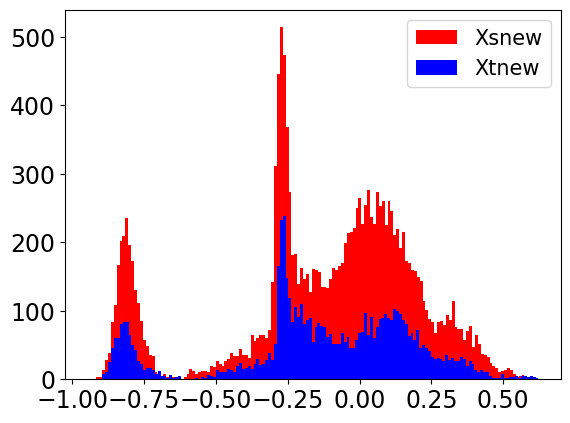

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color
img_flatXsnew = Xs_new.flatten()
img_flatXtnew = Xt_new.flatten()
#img_flatXtnew = np.random.choice(img_flatXtnew, 2200, replace=False)
#img_flatXsnew = np.random.choice(img_flatXsnew, 8888, replace=False)
n_bins = 150
xsnew_draw = [img_flatXsnew]
xtnew_draw = [img_flatXtnew]
#plt.xticks(fontsize=22)
##plt.yticks(fontsize=34)#
# colors = [ 'blue','red']
# labels = [ 'Xtnew','Xsnew']
plt.hist(xsnew_draw, n_bins, histtype='bar', stacked=True, color='red', label='Xsnew')
plt.hist(xtnew_draw, 150, histtype='bar', stacked=True, color='blue', label='Xtnew')
plt.legend(prop={'size': 15})
#plt.title('Probability Density after TCA')
plt.savefig('TCA_feature_distribution.pdf', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


~~~~I2P LINK with FTCA~~~~~~
~~~~Poly MAtrix~~~~~~
Results of sklearn.metrics of Poly:
MAE Poly: 0.20704071281492248
MSE Poly: 0.06489546647059517
RMSE Poly: 0.254745886071974
R-Squared Poly: 0.34439808522800597
######################
~~~~SVR MAtrix~~~~~~
Results of sklearn.metrics of SVR:
MAE SVR: 0.204967705763453
MSE SVR: 0.0639707723475852
RMSE SVR: 0.2529244399965832
R-Squared SVR: 0.3537397429830732
######################
~~~~MLP MAtrix~~~~~~
Results of sklearn.metrics of MLP:
MAE MLP: 0.21081166547160657
MSE MLP: 0.06409511875120749
RMSE MLP: 0.2531701379531312
R-Squared MLP: 0.3524835421304803
######################
~~~~RF MAtrix~~~~~~
Results of sklearn.metrics of RF:
MAE RF: 0.2211240310077519
MSE RF: 0.07038689662288257
RMSE RF: 0.2653052894739993
R-Squared RF: 0.28892129588544735
######################


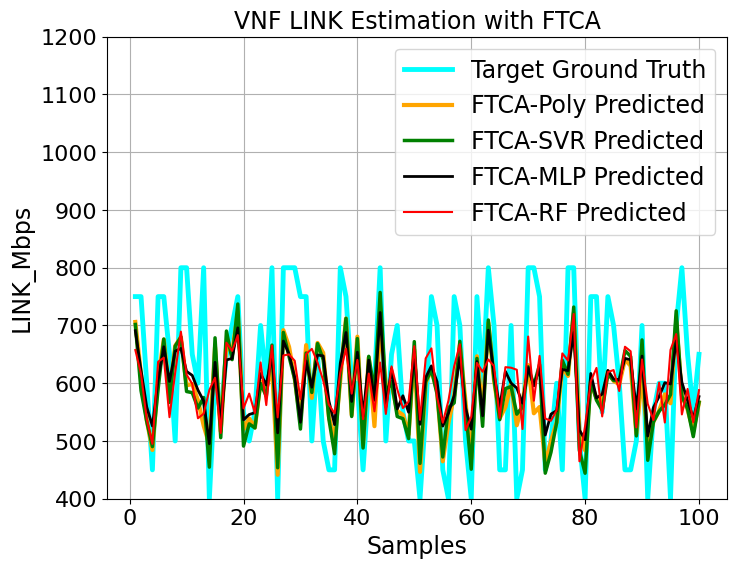

In [68]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov  5 16:21:26 2023

@author: Dan The Lable is MEM 算MAERMSE等指标的时候，不用可视化，把yt，ys 都minmax了就行，可视化不用minmax yt
"""
#######
# Step 1 - Load TCA Data
######################################
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics

# Initialize MinMaxScaler
#minmax_x = MinMaxScaler()
minmax_y = MinMaxScaler()

minmax_yt = MinMaxScaler()#######

# Fit and transform the training data
X = Xs_new
y = minmax_y.fit_transform(Ys)

yt = minmax_yt.fit_transform(Yt)#######

x_t = Xt_new

x_t = x_t[0:100,:]
y_t = Yt[0:100,:]
#######################################
#Step2 Load Benchmark Origional Data

Xs = Xs
Xt = Xt[0:100,:]

################################
### Polynomial Regression ###
################################

# ** NOTE - conver X to X_poly of required degree
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)

from sklearn.linear_model import LinearRegression
poly_regressor = LinearRegression()
poly_regressor.fit(X_poly, y)

################################
### SVR Regression ###
################################

# ** NOTE - SVR does not do feature scaling
from sklearn.svm import SVR
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(X, y)


################################
### MLP Regression ###
################################
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(
    activation='relu',
    hidden_layer_sizes=(10, 100),
    alpha=0.001, #regularization part
    early_stopping=False,
    max_iter=250
)
#
# Train the model
#
nn.fit(X, y)
####bench mark####


################################
### Random Forest Regression ###
################################
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor.fit(X, y.ravel())

################################
### Visualizations ###
################################
import matplotlib.pyplot as plt
import numpy as np

################################
X_axis = np.arange(1,101,1)
X_axis = X_axis.reshape((len(X_axis),1))
################################
plt.figure(figsize=(8,6))
plt.ylim(400, 1200)

plt.plot(X_axis, y_t,color="cyan",label='Target Ground Truth',lw =3.5)
#plt.scatter(X_axis, y_t,color="red",label='Ground Truth')

y_pol_pred = minmax_y.inverse_transform(poly_regressor.predict(poly_features.fit_transform(x_t)))

y_svr_pred = minmax_y.inverse_transform(svr_regressor.predict(x_t).reshape(-1, 1))

y_nn_pred = minmax_y.inverse_transform(nn.predict(x_t).reshape(-1, 1))

y_RF_pred = minmax_y.inverse_transform(forest_regressor.predict(x_t).reshape(-1, 1))

#y_svrno_pred = minmax_y.inverse_transform(svr_regressor_2.predict(Xt).reshape(-1, 1))


####################evalucation matrics here
y_pol_pred_val = poly_regressor.predict(poly_features.fit_transform(Xt_new))

y_svr_pred_val = svr_regressor.predict(Xt_new).reshape(-1, 1)

y_nn_pred_val = nn.predict(Xt_new).reshape(-1, 1)

y_RF_pred_val = forest_regressor.predict(Xt_new).reshape(-1, 1)

###################################################Pol
mae_poly = metrics.mean_absolute_error(yt, y_pol_pred_val)
mse_poly = metrics.mean_squared_error(yt, y_pol_pred_val)
rmse_poly = np.sqrt(mse_poly)
r2_poly = metrics.r2_score(yt,y_pol_pred_val)
print('~~~~I2P LINK with FTCA~~~~~~')
print('~~~~Poly MAtrix~~~~~~')
print("Results of sklearn.metrics of Poly:")
print("MAE Poly:",mae_poly)
print("MSE Poly:", mse_poly)
print("RMSE Poly:", rmse_poly)
print("R-Squared Poly:", r2_poly)
print('######################')
#########################################

###################################################SVR
mae_svr = metrics.mean_absolute_error(yt, y_svr_pred_val)
mse_svr = metrics.mean_squared_error(yt, y_svr_pred_val)
rmse_svr = np.sqrt(mse_svr)
r2_svr = metrics.r2_score(yt,y_svr_pred_val)
print('~~~~SVR MAtrix~~~~~~')
print("Results of sklearn.metrics of SVR:")
print("MAE SVR:",mae_svr)
print("MSE SVR:", mse_svr)
print("RMSE SVR:", rmse_svr)
print("R-Squared SVR:", r2_svr)
print('######################')
#########################################

###################################################DT
mae_nn = metrics.mean_absolute_error(yt, y_nn_pred_val)
mse_nn = metrics.mean_squared_error(yt, y_nn_pred_val)
rmse_nn = np.sqrt(mse_nn)
r2_nn = metrics.r2_score(yt,y_nn_pred_val)
print('~~~~MLP MAtrix~~~~~~')
print("Results of sklearn.metrics of MLP:")
print("MAE MLP:",mae_nn)
print("MSE MLP:", mse_nn)
print("RMSE MLP:", rmse_nn)
print("R-Squared MLP:", r2_nn)
print('######################')
#########################################

###################################################RF
mae_RF = metrics.mean_absolute_error(yt, y_RF_pred_val)
mse_RF = metrics.mean_squared_error(yt, y_RF_pred_val)
rmse_RF = np.sqrt(mse_RF)
r2_RF = metrics.r2_score(yt,y_RF_pred_val)
print('~~~~RF MAtrix~~~~~~')
print("Results of sklearn.metrics of RF:")
print("MAE RF:",mae_RF)
print("MSE RF:", mse_RF)
print("RMSE RF:", rmse_RF)
print("R-Squared RF:", r2_RF)
print('######################')
#########################################


plt.plot(X_axis, y_pol_pred, color="orange",label='FTCA-Poly Predicted',lw=3.0)
#plt.plot(X_axis, poly_regressor_2.predict(poly_features_2.fit_transform(Xt)), color="orange",label='Poly Predicted',lw=1, linestyle = 'dotted')

plt.plot(X_axis, y_svr_pred, color="green",label='FTCA-SVR Predicted',lw=2.5)
#plt.plot(X_axis, svr_regressor_2.predict(Xt),color="green",label='SVR Predicted',lw=1, linestyle = 'dotted')

plt.plot(X_axis, y_nn_pred, color="black",label='FTCA-MLP Predicted',lw = 2)
#plt.plot(X_axis, tree_regressor_2.predict(Xt), color="black",label='DT Predicted',linestyle = 'dotted')

plt.plot(X_axis, y_RF_pred, color="red",label='FTCA-RF Predicted',lw=1.5)


plt.rcParams['font.size'] = 17
plt.title("VNF LINK Estimation with FTCA",fontsize= 17)
plt.xlabel("Samples",fontsize= 17)
plt.ylabel("LINK_Mbps",fontsize= 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
#plt.figure(figsize=(20,10))
#fig = plt.gcf()
#fig.set_size_inches(10.5, 10)
plt.legend(loc='best')
plt.savefig('Regression compare_LINK.pdf', bbox_inches='tight')
plt.show()

=======================================================



In [69]:
# encoding=utf-8
#LINK prediction without TL

"""
    Created on 16.29 2023/11/09
    @author: dan
"""
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import scipy.io
import scipy.linalg
import os
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

src_domain = 'Inline.csv'
tar_domain = 'Passive.csv'

norm_scaler = MinMaxScaler()
dfs = pd.read_csv(src_domain)
dft = pd.read_csv(tar_domain)
dfs = dfs.sample(frac = 1)
dft = dft.sample(frac = 1)
labels=['LINK']#CPU MEM LINK
predictors = list(set(list(dfs.columns))-set(labels))
norm_Xs = norm_scaler.fit_transform(dfs[predictors])
norm_Xt = norm_scaler.fit_transform(dft[predictors])#normalization

#norm_Xs.dropna(axis=0)
dfs[labels].dropna(axis=0)
#norm_Xt.dropna(axis=0)
dft[labels].dropna(axis=0)

Xs = norm_Xs
Ys = dfs[labels].values
Xt = norm_Xt
Yt = dft[labels].values

minmax_ys = MinMaxScaler()
minmax_yt = MinMaxScaler()#######

ys = minmax_ys.fit_transform(Ys)
yt = minmax_yt.fit_transform(Yt)#######

################################Training
### Polynomial Regression ###
################################

# ** NOTE - conver X to X_poly of required degree
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(Xs)

from sklearn.linear_model import LinearRegression
poly_regressor = LinearRegression()
poly_regressor.fit(X_poly, ys)

################################
### SVR Regression ###
################################

# ** NOTE - SVR does not do feature scaling
from sklearn.svm import SVR
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(Xs, ys)


################################
### MLP Regression ###
################################
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(
    activation='relu',
    hidden_layer_sizes=(10, 100),
    alpha=0.001, #regularization part
    early_stopping=False,
    max_iter=150
)
#
# Train the model
#
nn.fit(Xs, ys)
####bench mark####


################################
### Random Forest Regression ###
################################
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor.fit(Xs, ys.ravel())


##############################Test
####################evalucation matrics here
y_pol_pred_oFTCA = poly_regressor.predict(poly_features.fit_transform(Xt))

y_svr_pred_oFTCA = svr_regressor.predict(Xt).reshape(-1, 1)

y_nn_pred_oFTCA = nn.predict(Xt).reshape(-1, 1)

y_RF_pred_oFTCA = forest_regressor.predict(Xt).reshape(-1, 1)

###################################################Pol
mae_poly = metrics.mean_absolute_error(yt, y_pol_pred_oFTCA)
mse_poly = metrics.mean_squared_error(yt, y_pol_pred_oFTCA)
rmse_poly = np.sqrt(mse_poly)
r2_poly = metrics.r2_score(yt,y_pol_pred_oFTCA)
print('~~~~LINK prediction without FTL~~~~')
print('~~~~Poly MAtrix Without FTCA~~~~~~')
print("Results of sklearn.metrics of Poly:")
print("MAE Poly:",mae_poly)
print("MSE Poly:", mse_poly)
print("RMSE Poly:", rmse_poly)
print("R-Squared Poly:", r2_poly)
print('######################')
#########################################

###################################################SVR
mae_svr = metrics.mean_absolute_error(yt, y_svr_pred_oFTCA)
mse_svr = metrics.mean_squared_error(yt, y_svr_pred_oFTCA)
rmse_svr = np.sqrt(mse_svr)
r2_svr = metrics.r2_score(yt,y_svr_pred_oFTCA)
print('~~~~SVR MAtrix Without FTCA~~~~~~')
print("Results of sklearn.metrics of SVR:")
print("MAE SVR:",mae_svr)
print("MSE SVR:", mse_svr)
print("RMSE SVR:", rmse_svr)
print("R-Squared SVR:", r2_svr)
print('######################')
#########################################

###################################################DT
mae_nn = metrics.mean_absolute_error(yt, y_nn_pred_oFTCA)
mse_nn = metrics.mean_squared_error(yt, y_nn_pred_oFTCA)
rmse_nn = np.sqrt(mse_nn)
r2_nn = metrics.r2_score(yt,y_nn_pred_oFTCA)
print('~~~~MLP MAtrix Without FTCA~~~~~~')
print("Results of sklearn.metrics of MLP:")
print("MAE MLP:",mae_nn)
print("MSE MLP:", mse_nn)
print("RMSE MLP:", rmse_nn)
print("R-Squared MLP:", r2_nn)
print('######################')
#########################################

###################################################RF
mae_RF = metrics.mean_absolute_error(yt, y_RF_pred_oFTCA)
mse_RF = metrics.mean_squared_error(yt, y_RF_pred_oFTCA)
rmse_RF = np.sqrt(mse_RF)
r2_RF = metrics.r2_score(yt,y_RF_pred_oFTCA)
print('~~~~RF MAtrix Without FTCA~~~~~~')
print("Results of sklearn.metrics of RF:")
print("MAE RF:",mae_RF)
print("MSE RF:", mse_RF)
print("RMSE RF:", rmse_RF)
print("R-Squared RF:", r2_RF)
print('######################')
#########################################

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


~~~~LINK prediction without FTL~~~~
~~~~Poly MAtrix Without FTCA~~~~~~
Results of sklearn.metrics of Poly:
MAE Poly: 0.17518528664780528
MSE Poly: 0.04602275552226754
RMSE Poly: 0.2145291484210655
R-Squared Poly: 0.5350583286560782
######################
~~~~SVR MAtrix Without FTCA~~~~~~
Results of sklearn.metrics of SVR:
MAE SVR: 0.20747922769677435
MSE SVR: 0.05843359625561732
RMSE SVR: 0.24173042062516112
R-Squared SVR: 0.40967867748427944
######################
~~~~MLP MAtrix Without FTCA~~~~~~
Results of sklearn.metrics of MLP:
MAE MLP: 0.17820466903501084
MSE MLP: 0.047183063712596604
RMSE MLP: 0.2172166285361151
R-Squared MLP: 0.5233363962519086
######################
~~~~RF MAtrix Without FTCA~~~~~~
Results of sklearn.metrics of RF:
MAE RF: 0.185069770005332
MSE RF: 0.05006523157658424
RMSE RF: 0.22375261244638964
R-Squared RF: 0.4942194968274969
######################


In [ ]:
y

array([[0.5  ],
       [0.75 ],
       [0.75 ],
       ...,
       [0.375],
       [0.125],
       [0.625]])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-39-63c1239c71ea>:78: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_regressor.fit(X, y)
<ipython-input-39-63c1239c71ea>:82: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_regressor_2.fit(Xs, y)


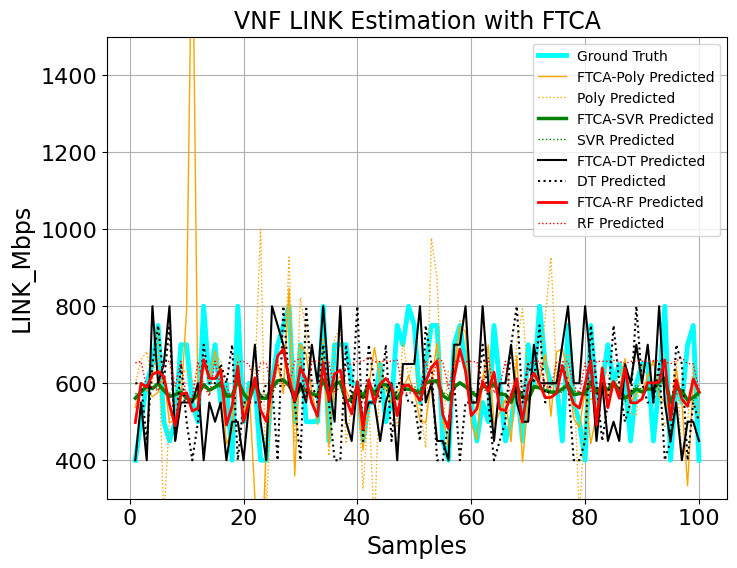

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov  5 16:21:26 2023

@author: Dan The Lable is LINK
"""
######
# Step 1 - Load TCA Data
######################################
X = Xs_new
y = Ys
x_t = Xt_new
x_t = x_t[0:100,:]
y_t = Yt[0:100,:]
#######################################
#Step2 Load Benchmark Origional Data

Xs = Xs
Xt = Xt[0:100,:]

################################
### Polynomial Regression ###
################################

# ** NOTE - conver X to X_poly of required degree
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=4)
X_poly = poly_features.fit_transform(X)

from sklearn.linear_model import LinearRegression
poly_regressor = LinearRegression()
poly_regressor.fit(X_poly, y)

#####Bencjmark poly#############
poly_features_2 = PolynomialFeatures(degree=4)
X_poly_2 = poly_features_2.fit_transform(Xs)

from sklearn.linear_model import LinearRegression
poly_regressor_2 = LinearRegression()
poly_regressor_2.fit(X_poly_2, y)

################################ model: poly_regressor_2


################################
### SVR Regression ###
################################

# ** NOTE - SVR does not do feature scaling
from sklearn.svm import SVR
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(X, y)
#######SVR bench marks#######
svr_regressor_2 = SVR(kernel="linear")
svr_regressor_2.fit(Xs, y)
############################### model: svr_regressor_2


################################
### Decision Tree Regression ###
################################
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(criterion="friedman_mse")
tree_regressor.fit(X, y)
####bench mark####

tree_regressor_2 = DecisionTreeRegressor(criterion="friedman_mse")
tree_regressor_2.fit(Xs, y)

##############################  model: tree_regressor_2

################################
### Random Forest Regression ###
################################
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor.fit(X, y)

#####bench mark####
forest_regressor_2 = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor_2.fit(Xs, y)

################################  model: forest_regressor_2

################################
### Visualizations ###
################################
import matplotlib.pyplot as plt
import numpy as np

################################
X_axis = np.arange(1,101,1)
X_axis = X_axis.reshape((len(X_axis),1))
################################
plt.figure(figsize=(8,6))
plt.ylim(300, 1500)

plt.plot(X_axis, y_t,color="cyan",label='Ground Truth',lw =3.5)
#plt.scatter(X_axis, y_t,color="red",label='Ground Truth')

plt.plot(X_axis, poly_regressor.predict(poly_features.fit_transform(x_t)), color="orange",label='FTCA-Poly Predicted',lw=1)
plt.plot(X_axis, poly_regressor_2.predict(poly_features_2.fit_transform(Xt)), color="orange",label='Poly Predicted',lw=1, linestyle = 'dotted')

plt.plot(X_axis, svr_regressor.predict(x_t), color="green",label='FTCA-SVR Predicted',lw=2.5)
plt.plot(X_axis, svr_regressor_2.predict(Xt),color="green",label='SVR Predicted',lw=1, linestyle = 'dotted')

plt.plot(X_axis, tree_regressor.predict(x_t), color="black",label='FTCA-DT Predicted')
plt.plot(X_axis, tree_regressor_2.predict(Xt), color="black",label='DT Predicted',linestyle = 'dotted')

plt.plot(X_axis, forest_regressor.predict(x_t), color="red",label='FTCA-RF Predicted',lw=2)
plt.plot(X_axis, forest_regressor_2.predict(Xt), color="red",label='RF Predicted',lw=1,linestyle = 'dotted')

#plt.xticks(np.arange(min(X), max(X)+1, 1))
#plt.yticks(np.arange(min(y), max(y)+1, 50000))
#plt.rcParams['font.size'] = 16
plt.title("VNF LINK Estimation with FTCA",fontsize= 17)
plt.xlabel("Samples",fontsize= 17)
plt.ylabel("LINK_Mbps",fontsize= 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
#plt.figure(figsize=(20,10))
#fig = plt.gcf()
#fig.set_size_inches(10.5, 10)
plt.legend(loc='best')
plt.savefig('Regression compare_LINK.pdf', bbox_inches='tight')
plt.show()